In [1]:
cd /home

/home


In [2]:
import tensorflow as tf
import pandas as pd 

import matplotlib.pyplot as plt

import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

%load_ext autoreload
%autoreload 2

from src.data.loaders import load_data

2023-07-24 17:33:26.577276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 17:33:26.710552: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## RECORDS

In [17]:
off_nsp = True
data = load_data('./data/records/macho_clean/test/',
                    batch_size=2500,
                    window_size=200,
                    probed=0.6,
                    random_same=.2,
                    sampling=True,
                    nsp_prob=.5,
                    test_mode=True,
                    off_nsp=off_nsp)


[INFO] Sampling random windows
[INFO] TESTING MODE


[2500 200 1]
[2500 200 1]
[2500 200 1]
[2500 200 1]


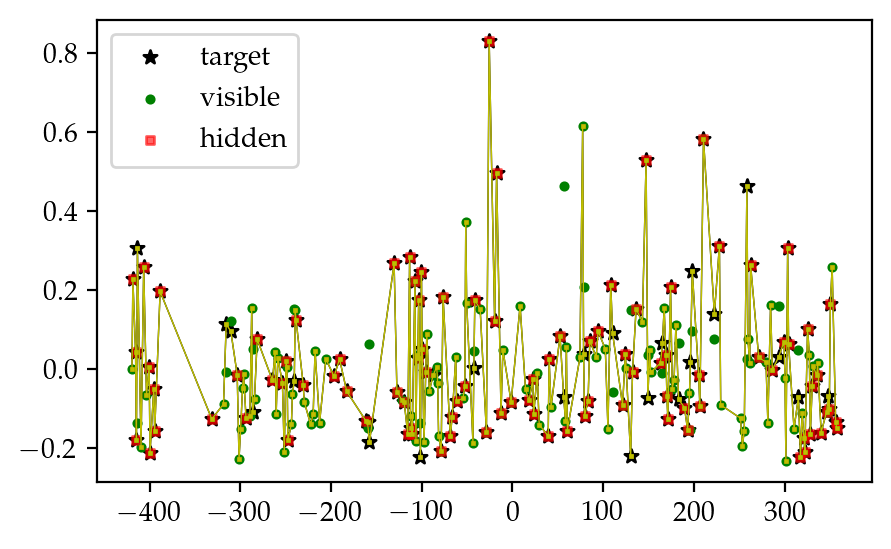

In [18]:
import numpy as np
plt.figure(figsize=(5, 3), dpi=200)
for x, y in data.take(1):
    
    N = 1
    start = 0 if off_nsp else 1

    original_lc   = x['original'][N]
    originak_mask = x['mask'][N]
    x_magn        = x['magnitudes'][N, start:, 0]
    x_time        = x['times'][N, start:, 0]
    att_mask      = x['att_mask'][N, start:, 0]        
    y_magn        = y['magnitudes'][N, :, 0]
    probed_mask   = y['probed_mask'][N, :, 0]
    
    # ASTROMER INPUT 
    magn_visible = tf.boolean_mask(x_magn, 1.-att_mask)    
    times_visible = tf.boolean_mask(x_time, 1.-att_mask)     
    magn_masked = tf.boolean_mask(x_magn, att_mask)
    times_masked = tf.boolean_mask(x_time, att_mask)
        
    # ASTROMER OUTPUT    
    x_probed = tf.boolean_mask(y_magn, probed_mask)
    time_probed=tf.boolean_mask(x_time, probed_mask)
    
    plt.plot(x_time, y_magn, linestyle='-', marker='s', 
             markersize=1,
             linewidth=0.5, color='k')
    
    plt.scatter(time_probed, x_probed, marker='*', 
                s=25, color='k', label='target')  
    plt.scatter(times_visible, magn_visible, marker='o', 
                s=7, color='g', label='visible')
    plt.scatter(times_masked, magn_masked, marker='s', 
                s=7, color='r', label='hidden', alpha=0.6)
  

    original_lc = tf.boolean_mask(original_lc, originak_mask)
    oritinal_time = tf.boolean_mask(x_time, originak_mask) 
    
    plt.plot(oritinal_time, original_lc[:, 1], linestyle='-', marker='s', 
             markersize=1,
             linewidth=0.5, color='y')
    
    plt.legend()

    if not off_nsp:
        if y['nsp_label'][N] == 1:
            plt.title('Non-Altered')
        else:
            plt.title('Altered')